Welcome to the **[30 Days of ML competition](https://www.kaggle.com/c/30-days-of-ml/overview)**!  In this notebook, you'll learn how to make your first submission.

Before getting started, make your own editable copy of this notebook by clicking on the **Copy and Edit** button.

# Step 1: Import helpful libraries

We begin by importing the libraries we'll need.  Some of them will be familiar from the **[Intro to Machine Learning](https://www.kaggle.com/learn/intro-to-machine-learning)** course and the **[Intermediate Machine Learning](https://www.kaggle.com/learn/intermediate-machine-learning)** course.

In [95]:
# Familiar imports
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from scipy import stats
from scipy.stats import norm, skew #for some statistics
from scipy.special import boxcox1p



# For ordinal encoding categorical variables, splitting data, pipeline, and so on
from sklearn.preprocessing import OrdinalEncoder, PowerTransformer, StandardScaler, MinMaxScaler, RobustScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score 
from sklearn.pipeline import make_pipeline

# For training random forest model
from sklearn.linear_model import ElasticNet, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor


from sklearn.metrics import mean_squared_error


In [96]:
pd.set_option("display.max_columns", 100)

# Step 2: Load the data

Next, we'll load the training and test data.  

We set `index_col=0` in the code cell below to use the `id` column to index the DataFrame.  (*If you're not sure how this works, try temporarily removing `index_col=0` and see how it changes the result.*)

In [97]:
# Load the training data
train = pd.read_csv("train.csv", index_col=0)
test = pd.read_csv("test.csv", index_col=0)

# Preview the data
train.head()
train.describe()

,cont0,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13,target
count,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000
mean,0.527335,0.460926,0.490498,0.496689,0.491654,0.510526,0.467476,0.537119,0.498456,0.474872,0.474492,0.473216,0.494561,0.508273,8.241979
std,0.230599,0.214003,0.253346,0.219199,0.240074,0.228232,0.210331,0.218140,0.239920,0.218007,0.255949,0.222022,0.247292,0.222950,0.746555
min,-0.118039,-0.069309,-0.056104,0.130676,0.255908,0.045915,-0.224689,0.203763,-0.260275,0.117896,0.048732,0.052608,-0.074208,0.151050,0.140329
25%,0.405965,0.310494,0.300604,0.329783,0.284188,0.354141,0.342873,0.355825,0.332486,0.306874,0.276017,0.308151,0.289074,0.300669,7.742071
50%,0.497053,0.427903,0.502462,0.465026,0.390470,0.488865,0.429383,0.504661,0.439151,0.434620,0.459975,0.433812,0.422887,0.472400,8.191373
75%,0.668060,0.615113,0.647512,0.664451,0.696599,0.669625,0.573383,0.703441,0.606056,0.614333,0.691579,0.642057,0.714502,0.758447,8.728634
max,1.058443,0.887253,1.034704,1.039560,1.055424,1.067649,1.111552,1.032837,1.040229,0.982922,1.055960,1.071444,0.975035,0.905992,10.411992


The next code cell separates the target (which we assign to `y`) from the training features (which we assign to `features`).

In [98]:
# Separate target from features
y = train['target']
features = train.drop(['target'], axis=1)

# Preview features
features.head()

,cat0,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,cont0,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13
id,,,,,,,,,,,,,,,,,,,,,,,,
1,B,B,B,C,B,B,A,E,C,N,0.201470,-0.014822,0.669699,0.136278,0.610706,0.400361,0.160266,0.310921,0.389470,0.267559,0.237281,0.377873,0.322401,0.869850
2,B,B,A,A,B,D,A,F,A,O,0.743068,0.367411,1.021605,0.365798,0.276853,0.533087,0.558922,0.516294,0.594928,0.341439,0.906013,0.921701,0.261975,0.465083
3,A,A,A,C,B,D,A,D,A,F,0.742708,0.310383,-0.012673,0.576957,0.285074,0.650609,0.375348,0.902567,0.555205,0.843531,0.748809,0.620126,0.541474,0.763846
4,B,B,A,C,B,D,A,E,C,K,0.429551,0.620998,0.577942,0.280610,0.284667,0.668980,0.239061,0.732948,0.679618,0.574844,0.346010,0.714610,0.540150,0.280682
6,A,A,A,C,B,D,A,E,A,N,1.058291,0.367492,-0.052389,0.232407,0.287595,0.686964,0.420667,0.648182,0.684501,0.956692,1.000773,0.776742,0.625849,0.250823


# Step 3: Prepare the data

Next, we'll need to handle the categorical columns (`cat0`, `cat1`, ... `cat9`).  

In the **[Categorical Variables lesson](https://www.kaggle.com/alexisbcook/categorical-variables)** in the Intermediate Machine Learning course, you learned several different ways to encode categorical variables in a dataset.  In this notebook, we'll use ordinal encoding and save our encoded features as new variables `X` and `X_test`.

In [99]:
def squared_features(df, cols):
    columns = df[cols].columns
    for c in columns:
        df[c + '_sq'] = df[c].pow(2)
    return df
        
# List of categorical columns
object_cols_long = [col for col in features.columns if 'cat' in col]
cont_cols = [col for col in features.columns if 'con' in col]

# new_features = squared_features(features, cont_cols)
# new_features.sample(10)

# skewness
for col in ('cont4')

new_features = features

In [100]:
new_features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 300000 entries, 1 to 499999
Data columns (total 24 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   cat0    300000 non-null  object 
 1   cat1    300000 non-null  object 
 2   cat2    300000 non-null  object 
 3   cat3    300000 non-null  object 
 4   cat4    300000 non-null  object 
 5   cat5    300000 non-null  object 
 6   cat6    300000 non-null  object 
 7   cat7    300000 non-null  object 
 8   cat8    300000 non-null  object 
 9   cat9    300000 non-null  object 
 10  cont0   300000 non-null  float64
 11  cont1   300000 non-null  float64
 12  cont2   300000 non-null  float64
 13  cont3   300000 non-null  float64
 14  cont4   300000 non-null  float64
 15  cont5   300000 non-null  float64
 16  cont6   300000 non-null  float64
 17  cont7   300000 non-null  float64
 18  cont8   300000 non-null  float64
 19  cont9   300000 non-null  float64
 20  cont10  300000 non-null  float64
 21  cont11  30

In [101]:
# ordinal-encode categorical columns
X = new_features.copy()
X_test = test.copy()

ordinal_encoder = OrdinalEncoder()
X[object_cols_long] = ordinal_encoder.fit_transform(features[object_cols_long])
X_test[object_cols_long] = ordinal_encoder.transform(test[object_cols_long])

In [102]:
#pd.plotting.scatter_matrix(features[con_cols], figsize=(15, 15));

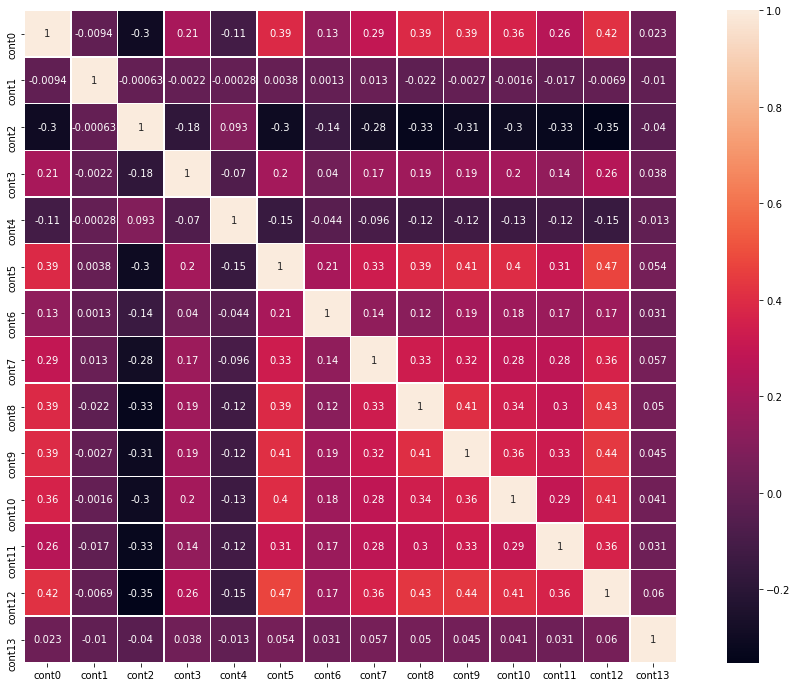

In [103]:
_, ax = plt.subplots(figsize=(18, 12))
sns.heatmap(new_features.corr(), annot=True, square=True,linewidths=.5, ax=ax);

Next, we break off a validation set from the training data.

In [104]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, random_state=0)

In [105]:
X_train.head().T

id,412957,282449,164867,541,80790
cat0,0.000000,0.000000,0.000000,0.000000,1.000000
cat1,0.000000,0.000000,0.000000,1.000000,1.000000
cat2,0.000000,0.000000,0.000000,0.000000,0.000000
cat3,2.000000,2.000000,0.000000,2.000000,2.000000
cat4,1.000000,1.000000,1.000000,1.000000,1.000000
cat5,2.000000,1.000000,1.000000,1.000000,3.000000
cat6,0.000000,0.000000,0.000000,0.000000,0.000000
cat7,3.000000,4.000000,4.000000,4.000000,4.000000
cat8,6.000000,4.000000,5.000000,4.000000,0.000000
cat9,7.000000,8.000000,14.000000,6.000000,8.000000


# Step 4.1: Predict using Stacking



In [215]:
# helper functions
def cv_score(model, X, y, scoring_method="neg_mean_squared_error", shuffle=True, k=5):
    
    kfolds = KFold(n_splits=k, 
                  shuffle=shuffle,
                  random_state=42)
    
    return cross_val_score(model, 
                            X, y, 
                            scoring=scoring_method,
                            cv = kfolds)

def rmse_score(model, X_train, y_train, X_valid, y_valid, **kwargs):
        model.fit(X_train, y_train, **kwargs)
        predictions = model.predict(X_valid)
        
        return mean_squared_error(predictions, y_valid, squared=False)

   
def kfold_train_predict(model, X, y, X_test,k=5, shuffle=True, use_eval_set=False, **kwargs):
    
    kfolds = KFold(n_splits=k, 
                  shuffle=shuffle,
                  random_state=42)
    
    test_predictions = 0
    valid_mean_score = [] 
    for fold, (train_index, valid_index) in enumerate(kfolds.split(X)):
        #print(fold, train_index, valid_index)
        X_train, X_valid = X.iloc[train_index], X.iloc[valid_index]
        y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
        
        model = clone(model)
        
        if use_eval_set:
            model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], **kwargs)
        else:
            model.fit(X_train, y_train, **kwargs)
        
        # validation score
        valid_predications = model.predict(X_valid)
        score = mean_squared_error(valid_predications, y_valid, squared=False)
        valid_mean_score.append(score)
        
        # test predictions
        test_predictions += model.predict(X_test) / k
        
        print('Fold:{} score:{:.4f}'.format(fold+1, score))
        
    print('average score:{:.4f} ({:.4f})'.format(np.mean(valid_mean_score), np.std(valid_mean_score) ))
    return test_predictions

### Base models

In [232]:

# lasso
lasso = make_pipeline(StandardScaler(), Lasso(alpha =0.0005, random_state=1))

# Elastic net
e_net = make_pipeline(StandardScaler(), ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=3))

# gradient boosing
gb = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05, 
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =5)

xgb_params = {'n_estimators': 10000,
              'learning_rate': 0.35,
              'subsample': 0.926,
              'colsample_bytree': 0.84,
              'max_depth': 2,
              'booster': 'gbtree', 
              'reg_lambda': 35.1,
              'reg_alpha': 34.9,
              'random_state': 42,
              'n_jobs': 4}

xgb = XGBRegressor(**xgb_params)


catb = CatBoostRegressor(iterations=6800,
                  learning_rate=0.93,
                  loss_function="RMSE",
                  random_state=42,
                  verbose=0,
                  thread_count=4,
                  depth=1,
                  l2_leaf_reg=3.28)

SEED = 7770777
params_lgb = {
    "n_estimators": 10000,   
    "boosting_type": "gbdt",
    "objective": "regression",
    "metric": "rmse",
    "learning_rate": 0.007899156646724397,
    "num_leaves": 77,
    "max_depth": 77,
    "feature_fraction": 0.2256038826485174,
    "bagging_fraction": 0.7705303688019942,
    "min_child_samples": 290,
    "reg_alpha": 9.562925363678952,
    "reg_lambda": 9.355810045480153,
    "max_bin": 772,
    "min_data_per_group": 177,
    "bagging_freq": 1,
    "cat_smooth": 96,
    "cat_l2": 17,
    "verbosity": -1,
    "bagging_seed": SEED,
    "feature_fraction_seed": SEED,
    "verbose_eval":1000,
    "seed": SEED
}

lgb = LGBMRegressor(**params_lgb)

#                    objective='regression',
#                    boosting_type="gbdt"
#                    learning_rate=0.01, 
#                    n_estimators=10000, 
#                    eval_set=[(X_valid, y_valid)],
#                    early_stopping_rounds=200,
#                    eval_metric='RMSE')


In [233]:
# baseline scores of each model

score_ = rmse_score(lasso, X_train.values, y_train.values, X_valid.values, y_valid.values)
print("\nLasso score: {:.4f} \n".format(score_))



Lasso score: 0.7414 



In [234]:
lasso_results = kfold_train_predict(lasso, X, y, X_test)

Fold:1 score:0.7385
Fold:2 score:0.7383
Fold:3 score:0.7397


KeyboardInterrupt: 

In [125]:
score_ = rmse_score(e_net, X_train, y_train, X_valid, y_valid)
print("ElasticNet score: {:.4f} \n".format(score_))


ElasticNet score: 0.7415 



In [219]:
lasso_results = kfold_train_predict(e_net, X, y, X_test)

Fold:1 score:0.7385
Fold:2 score:0.7384
Fold:3 score:0.7398
Fold:4 score:0.7394
Fold:5 score:0.7400
average score:0.7392 (0.0007)


array([8.10626504, 8.25488357, 8.28992299, ..., 8.2351315 , 8.24069116,
       8.2571474 ])

In [157]:
score_ = rmse_score(xgb, X_train, y_train, X_valid, y_valid, early_stopping_rounds=200,
                   eval_set=[(X_valid, y_valid)], verbose=False)
print("Xgboost score: {:.4f} \n".format(score_))

Xgboost score: 0.7194 



In [222]:
xgb_results = kfold_train_predict(xgb, X, y, X_test, use_eval_set=True,
                   early_stopping_rounds=200,
                   verbose=False)

Fold:1 score:0.7164
Fold:2 score:0.7162
Fold:3 score:0.7186
Fold:4 score:0.7183
Fold:5 score:0.7169
average score:0.7173 (0.0010)


In [187]:
score_ = rmse_score(lgb, X_train, y_train, X_valid, y_valid, 
                   eval_set=[(X_valid, y_valid)], 
                   early_stopping_rounds=200, verbose=False)
print("LGBM score: {:.4f} \n" .format(score_))

LGBM score: 0.7197 



In [226]:
lgb_results = kfold_train_predict(lgb, X, y, X_test, use_eval_set=True,
                   early_stopping_rounds=200,
                   verbose=False)

Fold:1 score:0.7168
Fold:2 score:0.7170
Fold:3 score:0.7188
Fold:4 score:0.7185
Fold:5 score:0.7172
average score:0.7177 (0.0008)


In [181]:
score_ = rmse_score(catb, X_train, y_train, X_valid, y_valid)
print("CatBoostRegressor score: {:.4f} \n" .format(score_))

Custom logger is already specified. Specify more than one logger at same time is not thread safe.

CatBoostRegressor score: 0.7207 



In [229]:
catb_results = kfold_train_predict(catb, X, y, X_test)

Fold:1 score:0.7176
Fold:2 score:0.7174
Fold:3 score:0.7189
Fold:4 score:0.7193
Fold:5 score:0.7177
average score:0.7182 (0.0008)


### First approach: simple averaging of predictions

In [230]:
from sklearn.base import BaseEstimator, RegressorMixin, TransformerMixin, clone
class RegressorsMixer(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, models, kwargs, weights):
        self.models = [clone(model) for model in models]
        self.weights = weights
        self.kwargs = kwargs
    
    def fit(self, X, y):
        for model, kwargs in zip(self.models, self.kwargs):
            
            model.fit(X, y, **kwargs)
            
        return self
    
    def predict(self, X):
        predictions = np.column_stack([model.predict(X) for model in self.models])
        return np.sum(predictions * self.weights, axis=1)

In [231]:
mix_regressors = RegressorsMixer(models=[lgb, xgb, catb],
                                 kwargs=[
                                         {'early_stopping_rounds':100,'eval_set':[(X_valid, y_valid)],'verbose':False},
                                         {'early_stopping_rounds':100,'eval_set':[(X_valid, y_valid)],'verbose':False},
                                           {}],
                                 weights=[0.30, 0.40, 0.30])
score_ = rmse_score(mix_regressors, X_train, y_train, X_valid, y_valid)
print("Averaged score from mix of models: {:.4f} \n" .format(score_))

KeyboardInterrupt: 

### Second approach: simple averaging of predictions with folds on each model

In this approach I am going to run k-folds using each model and average the rest results among folds.


In the code cell above, we set `squared=False` to get the root mean squared error (RMSE) on the validation data.

# Step 5: Submit to the competition

We'll begin by using the trained model to generate predictions, which we'll save to a CSV file.

In [188]:
best_model = mix_regressors
# Use the model to generate predictions
#best_model.fit(X, y)

In [ ]:
predictions = best_model.predict(X_test)



In [224]:
predictions = xgb_results
# Save the predictions to a CSV file
output = pd.DataFrame({'Id': X_test.index,
                       'target': predictions})
output.to_csv('submission.csv', index=False)

In [225]:
output.head(10)

,Id,target
0,0,8.072649
1,5,8.408605
2,15,8.371366
3,16,8.495113
4,17,8.143530
5,19,8.290678
6,20,8.514958
7,21,7.860616
8,23,8.082018
9,29,8.302702


In [80]:
r1 = np.random.random(size=(5,3))
r2 = [0.3, 0.1, 0]
r1

array([[0.67973625, 0.46831342, 0.60197872],
       [0.87685023, 0.91466869, 0.34780046],
       [0.08058471, 0.52488318, 0.53729717],
       [0.25987965, 0.04542818, 0.94995325],
       [0.67321723, 0.55177171, 0.9630213 ]])

In [81]:
r1.shape

(5, 3)

In [82]:
r2

[0.3, 0.1, 0]

In [85]:
r1 * r2

array([[0.20392088, 0.04683134, 0.        ],
       [0.26305507, 0.09146687, 0.        ],
       [0.02417541, 0.05248832, 0.        ],
       [0.07796389, 0.00454282, 0.        ],
       [0.20196517, 0.05517717, 0.        ]])

In [84]:
np.sum(r1 * r2, axis=1)

array([0.25075222, 0.35452194, 0.07666373, 0.08250671, 0.25714234])